In [60]:
# Imports

import requests
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import matplotlib
import plotly.express as px
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import cross_val_score

# Data Preparation

In [61]:
# Spotify API

# Access token to be used by default (may be out of date)
default_access_token = 'BQCfYByriYM9tu8aVkx4LlcS9GrfRGFEAJsndV8Co4ZTouPv1oKFKRIUWE3e4_DFspTt1y_U9SjpflEVuQAlh2KLDqzGpT3UU2ufhA-RblKtJo1N_iyH4XViOXyR_W9tthtCnOhCOvdKJH6-pVoeckmat4mbVrdf-4zA'
#'BQAFLe_uIEOZbroWKubXAzpqDYB5xqloPciCdkkGd7cMx8yOYTPQOvf1Qh3PfOIsQQzg_Pn5uG__JGaNkAfm0c2Ep5d0gUk89cpujUpjyaita7S1TEclEH2Wp9zGrZ6eBtgpMdL8ecPY3mg0IiHkrFwU6A6890aGWZjZn0CjEcWz'

# Gets the response from the given endpoint of Spotify's API
def spotify_api(endpoint, accesstoken=default_access_token):
    headers = {
        'Authorization' : f'Bearer {accesstoken}',
        'Content-Type' : 'application/json',
        'Accept' : 'application/json'
    }

    BASE_URL = 'https://api.spotify.com/v1/'

    url = BASE_URL + endpoint
    response = requests.get(url, headers = headers)
    dict_response = response.json()

    return dict_response

# Gets the ID of every song in a user's top-50 tracks
def get_top_track_ids(limit=50, offset=0):
    endpoint = f'me/top/tracks?limit={limit}&offset={offset}'
    search_results = spotify_api(endpoint)
    return [item['id'] for item in search_results['items']]

# Gets the ID of every song in a user's last 50 saved tracks
def get_saved_track_ids(limit=50, offset=0):
    endpoint = f'me/tracks?limit={limit}&offset={offset}'
    search_results = spotify_api(endpoint)
    return [item['track']['id'] for item in search_results['items']]

# Gets the audio features of a given song
def get_track_features(song_id):
    endpoint = f'audio-features/{song_id}'
    return spotify_api(endpoint)

In [62]:
# Gets the audio features of every song in a users' top tracks and saved tracks lists
def get_liked_songs_dataset():    
    song_ids = list({*get_top_track_ids(), *get_saved_track_ids()})
    song_dataset = pd.DataFrame([get_track_features(song) for song in song_ids])
    drop_cols = ['type', 'uri', 'track_href', 'analysis_url']
    song_dataset = song_dataset.drop(drop_cols, axis=1).set_index('id')
    # Set the class to 1; we know the user likes these songs
    song_dataset['liked'] = 1
    return song_dataset

# Gets the audio features of songs in the Kaggle dataset
def get_song_dataset(liked_song_ids, nrows=None):
    song_dataset = pd.read_csv('SpotifyAudioFeaturesApril2019.csv') if nrows is None else pd.read_csv('tracks_features.csv', nrows=nrows)
    drop_cols = ['track_name', 'artist_name', 'popularity']
    song_dataset = song_dataset.drop(drop_cols, axis=1).set_index('track_id')
    # Set the class to 0; we don't know if the user likes these songs
    song_dataset['liked'] = 0
    song_dataset = song_dataset.reset_index()
    return song_dataset[~song_dataset['track_id'].isin(liked_song_ids)].reset_index(drop=True).rename(columns={'track_id':'id'})

In [63]:
# We have a sample of a liked_songs DataFrame saved to a CSV for easier access
liked_songs = pd.read_csv('liked_songs.csv') # liked_songs = get_liked_songs_dataset()
unknown_songs = get_song_dataset(liked_songs['id'])
unknown_songs = unknown_songs.sample(frac=0.2)

In [64]:
print(liked_songs.shape)
liked_songs.head()

(100, 15)


,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,5OuJTtNve7FxUX82eEBupN,0.565,0.4380,7,-8.722,1,0.0311,0.1220,0.0469,0.108,0.211,133.949,361760,4,1
1,7bZP1hWx4jVnRUr0FgZ4nR,0.529,0.0759,2,-17.689,1,0.0331,0.6560,0.0000,0.156,0.353,139.683,221143,3,1
2,45bVeHyQHS7827SCXO6hh4,0.709,0.4010,5,-10.734,1,0.0367,0.7440,0.0264,0.119,0.491,74.023,228716,4,1
3,4Z84bBOAu0dLVd2WimB3re,0.590,0.6820,0,-7.223,1,0.0564,0.0198,0.0000,0.178,0.665,125.055,198572,4,1
4,0a0EYuSVqeVqV8kjN9bFYC,0.605,0.7240,1,-7.729,0,0.0441,0.1210,0.4310,0.108,0.898,89.403,226613,4,1


In [65]:
print(unknown_songs.shape)
unknown_songs.head()

(26131, 15)


,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,liked
114332,3VLxWIELhVz5F9w8yTFjkv,0.182,0.630,272053,0.7520,0.876,1,0.0697,-7.364,1,0.0409,100.001,4,0.132,0
105614,1YGKq15ZDWiRRVGbpwfjFa,0.966,0.347,144320,0.2820,0.455,6,0.1200,-17.712,1,0.0354,94.549,4,0.652,0
65452,60BsXa251U0uAj9pRJDXLp,0.887,0.160,207068,0.9560,0.774,2,0.4520,-17.205,0,0.0553,81.682,4,0.015,0
126548,40kU9OJ2myahlf1FRg2GJi,0.851,0.632,201143,0.2740,0.000,8,0.1080,-9.413,1,0.0321,96.839,4,0.146,0
95389,1j1XdHu5hqS3NrCibmkLpf,0.985,0.365,166933,0.0934,0.911,7,0.0804,-26.372,1,0.0552,134.584,4,0.846,0


In [66]:
def standardize_data(data):
    ids = data['id']
    classification = data['liked']
    data = data.drop(['id', 'liked'], axis=1)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data)
    data = pd.DataFrame(scaled_features, index=data.index, columns=data.columns)
    data['id'] = ids
    data['liked'] = classification
    
    return data

In [67]:
standardized_data = standardize_data(pd.concat([liked_songs, unknown_songs]))
liked_songs = standardized_data[standardized_data['liked'] == 1]
unknown_songs = standardized_data[standardized_data['liked'] == 0]

In [68]:
print(liked_songs.shape)
liked_songs.head()

(100, 15)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,liked
0,-0.092238,-0.508077,0.491297,0.191684,0.801443,-0.653805,-0.643253,-0.495217,-0.522950,-0.877689,0.481007,1.210835,0.233584,5OuJTtNve7FxUX82eEBupN,1
1,-0.282078,-1.899667,-0.895707,-1.182387,0.801443,-0.637728,0.905381,-0.625315,-0.232478,-0.331504,0.671176,0.072402,-1.712773,7bZP1hWx4jVnRUr0FgZ4nR,1
2,0.667123,-0.650272,-0.063505,-0.116628,0.801443,-0.608788,1.160586,-0.552083,-0.456383,0.199296,-1.506445,0.133713,0.233584,45bVeHyQHS7827SCXO6hh4,1
3,0.039596,0.429641,-1.450509,0.421386,0.801443,-0.450426,-0.939639,-0.625315,-0.099345,0.868565,0.186037,-0.110332,0.233584,4Z84bBOAu0dLVd2WimB3re,1
4,0.118696,0.591051,-1.173108,0.343848,-1.247749,-0.549302,-0.646153,0.570256,-0.522950,1.764770,-0.996366,0.116687,0.233584,0a0EYuSVqeVqV8kjN9bFYC,1


In [69]:
print(unknown_songs.shape)
unknown_songs.head()

(26131, 15)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,liked
114332,0.250529,0.698658,-1.173108,0.399779,0.801443,-0.575026,-0.469249,1.804662,-0.754722,-1.181552,-0.644882,0.484569,0.233584,3VLxWIELhVz5F9w8yTFjkv,0
105614,-1.241825,-1.107602,0.213896,-1.185912,0.801443,-0.619239,1.804400,0.636831,-0.450332,0.818562,-0.825698,-0.549555,0.233584,1YGKq15ZDWiRRVGbpwfjFa,0
65452,-2.227939,1.482652,-0.895707,-1.108221,-1.247749,-0.459268,1.575295,1.521720,1.558763,-1.631578,-1.252434,-0.041549,0.233584,60BsXa251U0uAj9pRJDXLp,0
126548,0.261076,-1.138347,0.768698,0.085798,0.801443,-0.645766,1.470893,-0.625315,-0.522950,-1.127703,-0.749750,-0.089517,0.233584,40kU9OJ2myahlf1FRg2GJi,0
95389,-1.146905,-1.832412,0.491297,-2.512940,0.801443,-0.460072,1.859501,1.901750,-0.689971,1.564758,0.502067,-0.366481,0.233584,1j1XdHu5hqS3NrCibmkLpf,0


# Feature Analysis

In [70]:
# Identify features with strong correlation and return the correlation matrix
def get_correlations(data):
    correlations = data.corr()
    existing_strongs = []
    for feature1, row in correlations.iterrows():
        for feature2 in row.keys():
            if feature1 != feature2:
                correlation = row[feature2]
                if abs(correlation) >= 0.7 and (feature1, feature2) not in existing_strongs:
                    existing_strongs.append((feature1, feature2))
                    existing_strongs.append((feature2, feature1))
                    print(f"Strong correlation between {feature1} and {feature2}: {correlation}")
    return correlations

In [71]:
print("Correlation of features for the user-identified 'liked' songs:")
get_correlations(liked_songs.drop('liked', axis=1))

Correlation of features for the user-identified 'liked' songs:
Strong correlation between energy and loudness: 0.7234921719762418


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
danceability,1.000000,0.096792,-0.119044,0.308719,0.087184,-0.044939,-0.171516,-0.106170,-0.115071,0.345127,0.143639,0.101410,0.452209
energy,0.096792,1.000000,-0.050297,0.723492,-0.224771,0.221104,-0.624220,0.165830,0.122552,0.356839,0.156499,-0.037210,0.231730
key,-0.119044,-0.050297,1.000000,-0.103554,0.000590,-0.067306,0.113624,-0.122393,0.027141,-0.147279,-0.034772,0.075474,-0.134473
loudness,0.308719,0.723492,-0.103554,1.000000,-0.052108,0.084829,-0.607560,0.003273,0.047702,0.383618,0.185362,0.086151,0.392915
mode,0.087184,-0.224771,0.000590,-0.052108,1.000000,-0.154750,0.153382,-0.341934,-0.265626,0.052199,0.005022,0.096189,0.130887
speechiness,-0.044939,0.221104,-0.067306,0.084829,-0.154750,1.000000,-0.132931,0.114757,0.182354,0.033439,0.149316,0.042920,0.140511
acousticness,-0.171516,-0.624220,0.113624,-0.607560,0.153382,-0.132931,1.000000,-0.172084,-0.065321,-0.229278,-0.230367,-0.169263,-0.321907
instrumentalness,-0.106170,0.165830,-0.122393,0.003273,-0.341934,0.114757,-0.172084,1.000000,0.126844,0.003104,0.018485,0.087600,0.071430
liveness,-0.115071,0.122552,0.027141,0.047702,-0.265626,0.182354,-0.065321,0.126844,1.000000,-0.004872,-0.088856,-0.285572,-0.060098
valence,0.345127,0.356839,-0.147279,0.383618,0.052199,0.033439,-0.229278,0.003104,-0.004872,1.000000,0.140173,-0.033993,0.285283


In [72]:
print("Correlation of feautres for the songs in the Kaggle dataset of 'unknown' songs:")
get_correlations(unknown_songs.drop('liked', axis=1))

Correlation of feautres for the songs in the Kaggle dataset of 'unknown' songs:
Strong correlation between energy and loudness: 0.7682558253057199
Strong correlation between energy and acousticness: -0.7077130054183206


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
danceability,1.000000,0.284806,0.012138,0.431852,-0.052862,0.246086,-0.355266,-0.307778,-0.123456,0.464989,0.076499,-0.126706,0.203876
energy,0.284806,1.000000,0.036610,0.768256,-0.072558,0.105967,-0.707713,-0.301605,0.220571,0.313390,0.223487,-0.027474,0.163496
key,0.012138,0.036610,1.000000,0.023420,-0.170878,0.010553,-0.015934,-0.019780,0.003546,0.038124,0.004686,0.003256,0.005445
loudness,0.431852,0.768256,0.023420,1.000000,-0.041140,0.080639,-0.601013,-0.509115,0.069560,0.317699,0.216482,-0.027221,0.178240
mode,-0.052862,-0.072558,-0.170878,-0.041140,1.000000,-0.054605,0.065594,0.005004,-0.003680,0.011734,-0.002452,0.010195,-0.037064
speechiness,0.246086,0.105967,0.010553,0.080639,-0.054605,1.000000,-0.122141,-0.226019,0.117261,0.125940,0.056498,-0.109844,0.061633
acousticness,-0.355266,-0.707713,-0.015934,-0.601013,0.065594,-0.122141,1.000000,0.270580,-0.116047,-0.174201,-0.208989,0.035968,-0.154496
instrumentalness,-0.307778,-0.301605,-0.019780,-0.509115,0.005004,-0.226019,0.270580,1.000000,-0.055860,-0.252944,-0.077101,0.040378,-0.082926
liveness,-0.123456,0.220571,0.003546,0.069560,-0.003680,0.117261,-0.116047,-0.055860,1.000000,-0.000070,-0.006514,-0.013900,-0.009976
valence,0.464989,0.313390,0.038124,0.317699,0.011734,0.125940,-0.174201,-0.252944,-0.000070,1.000000,0.097989,-0.140811,0.077873


In [73]:
print("Scatter matrix for audio features amongst 'liked' songs")
fig1 = px.scatter_matrix(liked_songs, dimensions = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence'])
fig1.show()

Scatter matrix for audio features amongst 'liked' songs


In [74]:
print("Scatter matrix for audio features amongst 'unknown' songs")
fig2 = px.scatter_matrix(unknown_songs.sample(100), dimensions = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence'])

fig2.show()

Scatter matrix for audio features amongst 'unknown' songs


# Train/Test Splitting

In [75]:
# Get training and testing datasets using SMOTE to balance class distribution
def get_train_test_datasets(liked_songs, unknown_songs, train_size_ratio):
    song_features = pd.concat([liked_songs, unknown_songs], axis=0).drop('id', axis=1)
    song_features = song_features.drop_duplicates(keep='first')
    shuffled_features = song_features.sample(frac=1)
    train_size = int(train_size_ratio*len(song_features))
    
    train_features = shuffled_features[:train_size]
    test_features = shuffled_features[train_size:]
    
    oversample = SMOTE()
    X = train_features.drop('liked', axis=1)
    y = train_features['liked']
    
    x_train, y_train = oversample.fit_resample(X, y)
    
    return test_features, x_train, y_train

In [76]:
test_features, X_train, y_train = get_train_test_datasets(liked_songs, unknown_songs, 0.8)

In [77]:
print(test_features.shape)
test_features.head()

(5235, 14)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
49586,-1.009798,-1.476541,1.323499,-0.865954,0.801443,-0.578241,1.560795,1.807436,-0.498744,-1.482339,0.545812,-0.789310,-1.712773,0
8676,-1.547679,1.182890,-0.063505,0.272133,0.801443,0.583353,-0.472149,-0.484398,-0.002522,-0.058411,0.071551,-1.393659,-1.712773,0
40678,1.046803,0.863912,-1.173108,0.826543,0.801443,0.623547,-0.672253,-0.625315,1.159365,0.218528,-1.307985,-0.369072,0.233584,0
25930,0.656576,-0.969250,1.046099,-0.489452,-1.247749,6.604351,-0.011039,-0.625315,0.439237,1.264741,-0.871765,-1.264317,0.233584,0
62377,0.646029,-0.777095,1.323499,-1.214414,-1.247749,-0.560556,-0.002339,1.871237,1.443785,-1.208477,-0.379627,0.229375,0.233584,0


In [78]:
print(X_train.shape)
X_train.head()

(41720, 13)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,-0.598478,1.425006,-1.450509,0.407901,0.801443,-0.564575,-0.996918,-0.616882,-0.640349,-0.069950,-0.998522,0.597969,0.233584
1,0.218889,0.391210,1.046099,0.565275,0.801443,-0.538851,0.484872,-0.625293,-0.714782,1.784002,1.514432,0.113198,0.233584
2,-1.136358,1.624847,-1.173108,0.863013,0.801443,0.808437,-0.992855,-0.625309,3.029276,-1.212323,2.012970,-0.838201,0.233584
3,0.234709,0.225956,-0.063505,-0.548908,-1.247749,-0.577437,-0.839877,1.982195,2.769062,-0.189188,0.050823,1.333408,0.233584
4,0.820050,1.286654,-0.340906,0.704414,-1.247749,-0.400586,-0.755195,-0.625289,0.989923,1.283973,2.006271,-0.082749,0.233584


In [79]:
print(y_train.shape)
y_train.head()

(41720,)


0    0
1    0
2    0
3    0
4    0
Name: liked, dtype: int64

In [80]:
X_test = test_features.drop(columns=['liked'])
y_test = test_features['liked']

In [81]:
print(X_test.shape)
X_test.head()

(5235, 13)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
49586,-1.009798,-1.476541,1.323499,-0.865954,0.801443,-0.578241,1.560795,1.807436,-0.498744,-1.482339,0.545812,-0.789310,-1.712773
8676,-1.547679,1.182890,-0.063505,0.272133,0.801443,0.583353,-0.472149,-0.484398,-0.002522,-0.058411,0.071551,-1.393659,-1.712773
40678,1.046803,0.863912,-1.173108,0.826543,0.801443,0.623547,-0.672253,-0.625315,1.159365,0.218528,-1.307985,-0.369072,0.233584
25930,0.656576,-0.969250,1.046099,-0.489452,-1.247749,6.604351,-0.011039,-0.625315,0.439237,1.264741,-0.871765,-1.264317,0.233584
62377,0.646029,-0.777095,1.323499,-1.214414,-1.247749,-0.560556,-0.002339,1.871237,1.443785,-1.208477,-0.379627,0.229375,0.233584


In [82]:
print(y_test.shape)
y_test.head()

(5235,)


49586    0
8676     0
40678    0
25930    0
62377    0
Name: liked, dtype: int64

# Model Analysis

In [83]:
model_performance = []

### Logistic Regression

In [84]:
lregression = LogisticRegression(max_iter=10000).fit(X_train, y_train)
thresholds = [0.01, 0.1, 0.25, 0.33, 0.5, 0.67, 0.75, 0.9, 0.99]
lregression_results = []
for threshold in thresholds:
    y_train_pred = np.where(lregression.predict_proba(X_train)[:,1] > threshold, 1, 0)
    y_test_pred = np.where(lregression.predict_proba(X_test)[:,1] > threshold, 1, 0)
    lregression_results.append({
        'Threshold': threshold,
        'Train Accuracy': metrics.accuracy_score(y_train, y_train_pred),
        'Train Error': 1 - metrics.accuracy_score(y_train, y_train_pred),
        'Train Precision': metrics.precision_score(y_train, y_train_pred, zero_division=1),
        'Train Recall': metrics.recall_score(y_train, y_train_pred, zero_division=1),
        'Train F1': metrics.f1_score(y_train, y_train_pred, zero_division=1),
        'Train AUC': metrics.roc_auc_score(y_train, y_train_pred),
        'Test Accuracy': metrics.accuracy_score(y_test, y_test_pred),
        'Test Error': 1 - metrics.accuracy_score(y_test,y_test_pred),
        'Test Precision': metrics.precision_score(y_test, y_test_pred, zero_division=1),
        'Test Recall': metrics.recall_score(y_test, y_test_pred, zero_division=1),
        'Test F1': metrics.f1_score(y_test, y_test_pred, zero_division=1),
        'Test AUC': metrics.roc_auc_score(y_test, y_test_pred)
    })
for model in lregression_results:
    model_performance.append({
        'model': 'LR',
        'Test Accuracy': model['Test Accuracy'],
        'Test AUC': model['Test AUC']
    })
pd.DataFrame(lregression_results)

,Threshold,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1,Train AUC,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1,Test AUC
0,0.01,0.542953,0.457047,0.522440,1.000000,0.686320,0.542953,0.085960,0.914040,0.004370,1.000000,0.008701,0.541139
1,0.10,0.656783,0.343217,0.594221,0.988782,0.742330,0.656783,0.322254,0.677746,0.005884,1.000000,0.011699,0.659762
2,0.25,0.709444,0.290556,0.637131,0.973106,0.770068,0.709444,0.442598,0.557402,0.006810,0.952381,0.013523,0.696463
3,0.33,0.723562,0.276438,0.654630,0.946453,0.773947,0.723562,0.503916,0.496084,0.007645,0.952381,0.015169,0.727245
4,0.50,0.746500,0.253500,0.705746,0.845542,0.769345,0.746500,0.658262,0.341738,0.008889,0.761905,0.017573,0.709875
5,0.67,0.681783,0.318217,0.761265,0.529674,0.624696,0.681783,0.836485,0.163515,0.012835,0.523810,0.025057,0.680777
6,0.75,0.623130,0.376870,0.795672,0.331352,0.467865,0.623130,0.916523,0.083477,0.014019,0.285714,0.026726,0.602389
7,0.90,0.502996,0.497004,0.722420,0.009732,0.019204,0.502996,0.992932,0.007068,0.000000,0.000000,0.000000,0.498466
8,0.99,0.500000,0.500000,1.000000,0.000000,0.000000,0.500000,0.995989,0.004011,1.000000,0.000000,0.000000,0.500000


### Naive Bayes

In [85]:
nb_models = ['GaussianNB']
nbayes_results = []
for nb_model in nb_models:
    if nb_model == 'GaussianNB':
        nbayes = GaussianNB()
    nbayes.fit(X_train, y_train)
    y_train_pred = nbayes.predict(X_train)
    y_test_pred = nbayes.predict(X_test)
    nbayes_results.append({
        'NB Model': nb_model,
        'Train Accuracy': metrics.accuracy_score(y_train, y_train_pred),
        'Train Error': 1 - metrics.accuracy_score(y_train, y_train_pred),
        'Train Precision': metrics.precision_score(y_train, y_train_pred, zero_division=1),
        'Train Recall': metrics.recall_score(y_train, y_train_pred, zero_division=1),
        'Train F1': metrics.f1_score(y_train, y_train_pred, zero_division=1),
        'Train AUC': metrics.roc_auc_score(y_train, y_train_pred),
        'Test Accuracy': metrics.accuracy_score(y_test, y_test_pred),
        'Test Error': 1 - metrics.accuracy_score(y_test,y_test_pred),
        'Test Precision': metrics.precision_score(y_test, y_test_pred, zero_division=1),
        'Test Recall': metrics.recall_score(y_test, y_test_pred, zero_division=1),
        'Test F1': metrics.f1_score(y_test, y_test_pred, zero_division=1),
        'Test AUC': metrics.roc_auc_score(y_test, y_test_pred)
    })
for model in nbayes_results:
    model_performance.append({
        'model': 'NB',
        'Test Accuracy': model['Test Accuracy'],
        'Test AUC': model['Test AUC']
    })
pd.DataFrame(nbayes_results)

,NB Model,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1,Train AUC,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1,Test AUC
0,GaussianNB,0.745566,0.254434,0.681952,0.920374,0.783425,0.745566,0.571538,0.428462,0.007972,0.857143,0.015796,0.713765


### Decision Tree

In [86]:
splitting_criteria = ['entropy', 'gini']
depths = [1, 5, 10, 20, 50, 100]
dtree_results = []
for criterion in splitting_criteria:
    for depth in depths:
        dtree = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
        dtree.fit(X_train, y_train)
        y_train_pred = dtree.predict(X_train)
        y_test_pred = dtree.predict(X_test)
        dtree_results.append({
            'Criterion': criterion,
            'Depth': depth,
            'Train Accuracy': metrics.accuracy_score(y_train, y_train_pred),
            'Train Error': 1 - metrics.accuracy_score(y_train, y_train_pred),
            'Train Precision': metrics.precision_score(y_train, y_train_pred, zero_division=1),
            'Train Recall': metrics.recall_score(y_train, y_train_pred, zero_division=1),
            'Train F1': metrics.f1_score(y_train, y_train_pred, zero_division=1),
            'Train AUC': metrics.roc_auc_score(y_train, y_train_pred),
            'Test Accuracy': metrics.accuracy_score(y_test, y_test_pred),
            'Test Error': 1 - metrics.accuracy_score(y_test,y_test_pred),
            'Test Precision': metrics.precision_score(y_test, y_test_pred, zero_division=1),
            'Test Recall': metrics.recall_score(y_test, y_test_pred, zero_division=1),
            'Test F1': metrics.f1_score(y_test, y_test_pred, zero_division=1),
            'Test AUC': metrics.roc_auc_score(y_test, y_test_pred)
        })
for model in dtree_results:
    model_performance.append({
        'model': 'DT',
        'Test Accuracy': model['Test Accuracy'],
        'Test AUC': model['Test AUC']
    })
pd.DataFrame(dtree_results)

,Criterion,Depth,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1,Train AUC,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1,Test AUC
0,entropy,1,0.627733,0.372267,0.573219,1.000000,0.728721,0.627733,0.252340,0.747660,0.005337,1.000000,0.010617,0.624664
1,entropy,5,0.797100,0.202900,0.758649,0.871429,0.811138,0.797100,0.727603,0.272397,0.009085,0.619048,0.017906,0.673544
2,entropy,10,0.924569,0.075431,0.878434,0.985523,0.928902,0.924569,0.868386,0.131614,0.010264,0.333333,0.019915,0.601937
3,entropy,20,0.984971,0.015029,0.971258,0.999521,0.985187,0.984971,0.959503,0.040497,0.015228,0.142857,0.027523,0.552825
4,entropy,50,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.982044,0.017956,0.013333,0.047619,0.020833,0.516713
5,entropy,100,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.982044,0.017956,0.000000,0.000000,0.000000,0.493000
6,gini,1,0.628092,0.371908,0.573467,0.999856,0.728883,0.628092,0.253868,0.746132,0.005348,1.000000,0.010638,0.625432
7,gini,5,0.799233,0.200767,0.764402,0.865101,0.811640,0.799233,0.741165,0.258835,0.009559,0.619048,0.018827,0.680352
8,gini,10,0.929914,0.070086,0.879550,0.996261,0.934274,0.929914,0.866094,0.133906,0.010086,0.333333,0.019580,0.600786
9,gini,20,0.978044,0.021956,0.957977,0.999952,0.978515,0.978044,0.945941,0.054059,0.018382,0.238095,0.034130,0.593443


### Random Forest

In [87]:
# Best criterion and depth based on our analysis of the Decision Tree results
best_criterion = 'gini'
best_depth = 20
Ts = [10, 50, 100, 500]
rforest_results = []
for T in Ts:
    rforest = RandomForestClassifier(n_estimators=T, max_depth=best_depth, criterion=best_criterion)
    rforest.fit(X_train, y_train)
    y_train_pred = rforest.predict(X_train)
    y_test_pred = rforest.predict(X_test)
    rforest_results.append({
        'Estimators': T,
        'Train Accuracy': metrics.accuracy_score(y_train, y_train_pred),
        'Train Error': 1 - metrics.accuracy_score(y_train, y_train_pred),
        'Train Precision': metrics.precision_score(y_train, y_train_pred, zero_division=1),
        'Train Recall': metrics.recall_score(y_train, y_train_pred, zero_division=1),
        'Train F1': metrics.f1_score(y_train, y_train_pred, zero_division=1),
        'Train AUC': metrics.roc_auc_score(y_train, y_train_pred),
        'Test Accuracy': metrics.accuracy_score(y_test, y_test_pred),
        'Test Error': 1 - metrics.accuracy_score(y_test,y_test_pred),
        'Test Precision': metrics.precision_score(y_test, y_test_pred, zero_division=1),
        'Test Recall': metrics.recall_score(y_test, y_test_pred, zero_division=1),
        'Test F1': metrics.f1_score(y_test, y_test_pred, zero_division=1),
        'Test AUC': metrics.roc_auc_score(y_test, y_test_pred)
    })
for model in rforest_results:
    model_performance.append({
        'model': 'RF',
        'Test Accuracy': model['Test Accuracy'],
        'Test AUC': model['Test AUC']
    })
pd.DataFrame(rforest_results)

,Estimators,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1,Train AUC,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1,Test AUC
0,10,0.986002,0.013998,0.972810,0.999952,0.986195,0.986002,0.971347,0.028653,0.015038,0.095238,0.025974,0.535057
1,50,0.986314,0.013686,0.973356,1.000000,0.986498,0.986314,0.972684,0.027316,0.015873,0.095238,0.027211,0.535728
2,100,0.986337,0.013663,0.973402,1.000000,0.986522,0.986337,0.972493,0.027507,0.023256,0.142857,0.040000,0.559346
3,500,0.986673,0.013327,0.974038,1.000000,0.986848,0.986673,0.971729,0.028271,0.015267,0.095238,0.026316,0.535249


### AdaBoost

In [88]:
base_estimators = [
    LogisticRegression(max_iter=10000),
    GaussianNB(),
    DecisionTreeClassifier(criterion=best_criterion, max_depth=best_depth)
]
aboost_results = []
for base_estimator in base_estimators:
    for classifiers in [10, 50, 100, 500]:
        aboost = AdaBoostClassifier(n_estimators=classifiers, base_estimator=base_estimator)
        aboost.fit(X=X_train, y=y_train)
        y_train_pred = aboost.predict(X_train)
        y_test_pred = aboost.predict(X_test)
        aboost_results.append({
            'Base Estimator': type(base_estimator).__name__,
            'Classifiers': classifiers,
            'Train Accuracy': metrics.accuracy_score(y_train, y_train_pred),
            'Train Error': 1 - metrics.accuracy_score(y_train, y_train_pred),
            'Train Precision': metrics.precision_score(y_train, y_train_pred, zero_division=1),
            'Train Recall': metrics.recall_score(y_train, y_train_pred, zero_division=1),
            'Train F1': metrics.f1_score(y_train, y_train_pred, zero_division=1),
            'Train AUC': metrics.roc_auc_score(y_train, y_train_pred),
            'Test Accuracy': metrics.accuracy_score(y_test, y_test_pred),
            'Test Error': 1 - metrics.accuracy_score(y_test,y_test_pred),
            'Test Precision': metrics.precision_score(y_test, y_test_pred, zero_division=1),
            'Test Recall': metrics.recall_score(y_test, y_test_pred, zero_division=1),
            'Test F1': metrics.f1_score(y_test, y_test_pred, zero_division=1),
            'Test AUC': metrics.roc_auc_score(y_test, y_test_pred)
        })
for model in aboost_results:
    model_performance.append({
        'model': 'AB',
        'Test Accuracy': model['Test Accuracy'],
        'Test AUC': model['Test AUC']
    })
pd.DataFrame(aboost_results)

,Base Estimator,Classifiers,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1,Train AUC,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1,Test AUC
0,LogisticRegression,10,0.746213,0.253787,0.707969,0.838159,0.767583,0.746213,0.658835,0.341165,0.007808,0.666667,0.015436,0.662735
1,LogisticRegression,50,0.741898,0.258102,0.701276,0.842809,0.765556,0.741898,0.649857,0.350143,0.008143,0.714286,0.016103,0.681941
2,LogisticRegression,100,0.741012,0.258988,0.700371,0.842426,0.764858,0.741012,0.653868,0.346132,0.008777,0.761905,0.017354,0.707669
3,LogisticRegression,500,0.740772,0.259228,0.699996,0.842713,0.764753,0.740772,0.652149,0.347851,0.008734,0.761905,0.017269,0.706806
4,GaussianNB,10,0.533054,0.466946,0.579665,0.240508,0.339963,0.533054,0.826361,0.173639,0.008850,0.380952,0.017297,0.604554
5,GaussianNB,50,0.517306,0.482694,0.562958,0.154746,0.242762,0.517306,0.883095,0.116905,0.005025,0.142857,0.009709,0.514467
6,GaussianNB,100,0.537248,0.462752,0.552664,0.390892,0.457910,0.537248,0.691691,0.308309,0.004356,0.333333,0.008600,0.513234
7,GaussianNB,500,0.537248,0.462752,0.552664,0.390892,0.457910,0.537248,0.691691,0.308309,0.004356,0.333333,0.008600,0.513234
8,DecisionTreeClassifier,10,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.993887,0.006113,0.000000,0.000000,0.000000,0.498945
9,DecisionTreeClassifier,50,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.995415,0.004585,0.000000,0.000000,0.000000,0.499712


### Neural Network

In [89]:
activations = ['identity', 'logistic', 'tanh', 'relu']
nnetwork_results = []
for activation in activations:
    nnetwork = MLPClassifier(activation=activation)
    nnetwork.fit(X_train, y_train)
    y_train_pred = nnetwork.predict(X_train)
    y_test_pred = nnetwork.predict(X_test)
    nnetwork_results.append({
        'Activation': activation,
        'Train Accuracy': metrics.accuracy_score(y_train, y_train_pred),
        'Train Error': 1 - metrics.accuracy_score(y_train, y_train_pred),
        'Train Precision': metrics.precision_score(y_train, y_train_pred, zero_division=1),
        'Train Recall': metrics.recall_score(y_train, y_train_pred, zero_division=1),
        'Train F1': metrics.f1_score(y_train, y_train_pred, zero_division=1),
        'Train AUC': metrics.roc_auc_score(y_train, y_train_pred),
        'Test Accuracy': metrics.accuracy_score(y_test, y_test_pred),
        'Test Error': 1 - metrics.accuracy_score(y_test,y_test_pred),
        'Test Precision': metrics.precision_score(y_test, y_test_pred, zero_division=1),
        'Test Recall': metrics.recall_score(y_test, y_test_pred, zero_division=1),
        'Test F1': metrics.f1_score(y_test, y_test_pred, zero_division=1),
        'Test AUC': metrics.roc_auc_score(y_test, y_test_pred)
    })
for model in nnetwork_results:
    model_performance.append({
        'model': 'NN',
        'Test Accuracy': model['Test Accuracy'],
        'Test AUC': model['Test AUC']
    })
pd.DataFrame(nnetwork_results)

C:\Users\payto\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\payto\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\payto\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



,Activation,Train Accuracy,Train Error,Train Precision,Train Recall,Train F1,Train AUC,Test Accuracy,Test Error,Test Precision,Test Recall,Test F1,Test AUC
0,identity,0.744487,0.255513,0.703463,0.845302,0.767887,0.744487,0.656543,0.343457,0.008845,0.761905,0.017486,0.709011
1,logistic,0.996021,0.003979,0.992105,1.000000,0.996037,0.996021,0.983381,0.016619,0.014706,0.047619,0.022472,0.517385
2,tanh,0.999545,0.000455,0.999090,1.000000,0.999545,0.999545,0.988921,0.011079,0.025641,0.047619,0.033333,0.520165
3,relu,0.999736,0.000264,0.999473,1.000000,0.999736,0.999736,0.989494,0.010506,0.027778,0.047619,0.035088,0.520453


# Model Comparison

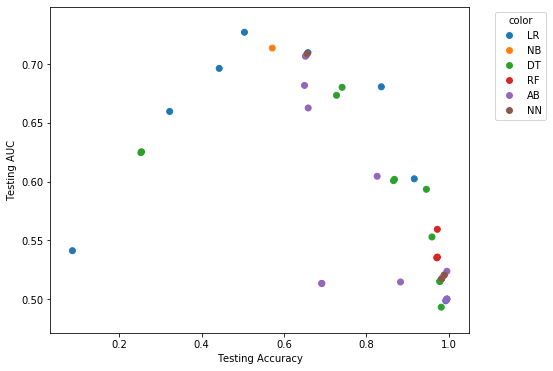

In [90]:
colors = {
    'LR':'tab:blue', 
    'NB':'tab:orange', 
    'DT':'tab:green', 
    'RF':'tab:red', 
    'AB':'tab:purple', 
    'NN':'tab:brown'
}
model_performance_df = pd.DataFrame(model_performance)
model_performance_df.to_csv("model_performance.csv")
plt.figure(figsize=(7.5, 6))
plt.scatter(model_performance_df['Test Accuracy'], model_performance_df['Test AUC'], c=model_performance_df['model'].map(colors))
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Testing Accuracy")
plt.ylabel("Testing AUC")
plt.show()

# Cross-Validation Asessment

In [91]:
empty, features, target = get_train_test_datasets(liked_songs, unknown_songs, 1)
best_models = [
    LogisticRegression(max_iter=10000),
    GaussianNB(),
    DecisionTreeClassifier(criterion='entropy', max_depth=20),
    RandomForestClassifier(n_estimators=100, max_depth=20, criterion='entropy'),
    AdaBoostClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=10)),
    MLPClassifier(activation='tanh')
]
model_cross_val_results = []
for model in best_models:
    accuracy = cross_val_score(model, features, target, scoring='accuracy')
    precision = cross_val_score(model, features, target, scoring='precision')
    recall = cross_val_score(model, features, target, scoring='recall')
    f1 = cross_val_score(model, features, target, scoring='f1')
    auc = cross_val_score(model, features, target, scoring='roc_auc')
    model_cross_val_results.append({
        'model': type(model).__name__,
        'accuracy': accuracy.mean(),
        'error': 1 - accuracy.mean(),
        'precision': precision.mean(),
        'recall': recall.mean(),
        'f1': f1.mean(),
        'auc': auc.mean()
    })
pd.DataFrame(model_cross_val_results)

C:\Users\payto\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\payto\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\payto\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\payto\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\payto\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Opt

,model,accuracy,error,precision,recall,f1,auc
0,LogisticRegression,0.738993,0.261007,0.695051,0.851653,0.765415,0.804864
1,GaussianNB,0.746778,0.253222,0.682228,0.923947,0.784895,0.864373
2,DecisionTreeClassifier,0.969510,0.030490,0.949373,0.991409,0.969949,0.979554
3,RandomForestClassifier,0.987094,0.012906,0.976513,0.999616,0.988077,0.999670
4,AdaBoostClassifier,0.997200,0.002800,0.995452,0.998926,0.996709,0.999855
5,MLPClassifier,0.993308,0.006692,0.986980,1.000000,0.992879,0.998721


# Variable Importance

In [99]:
variable_importances = list(RandomForestClassifier(n_estimators=100, max_depth=20, criterion='entropy').fit(X=X_train, y=y_train).feature_importances_)
variable_importances_dict = []
for i in range(len(X_train.columns)):
    variable_dict = {}
    variable_dict["Variable"] = list(X_train.columns)[i]
    variable_dict["Importance"] = variable_importances[i]
    variable_importances_dict.append(variable_dict)
variable_importances_df = pd.DataFrame(variable_importances_dict)
variable_importances_df.sort_values('Importance', ascending=False)

,Variable,Importance
7,instrumentalness,0.181363
2,key,0.098624
5,speechiness,0.088503
0,danceability,0.086830
3,loudness,0.086810
6,acousticness,0.085714
1,energy,0.077733
11,duration_ms,0.068115
9,valence,0.060046
8,liveness,0.051236


In [100]:
results_plot = px.bar(variable_importances_df, x="Variable", y="Importance")
results_plot.update_xaxes(type='category')
results_plot.show()

# IRL Testing

In [93]:
# Generate a playlist of the 10 highest recommended songs
def playlist_generator(liked_songs, unknown_songs):
    test_features, X_train, y_train = get_train_test_datasets(liked_songs, unknown_songs, 0.8)
    X_test = test_features.drop(columns=['liked'])
    y_test = test_features['liked']
    aboost = AdaBoostClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=10))
    aboost.fit(X_train, y_train)
    y_test_pred = aboost.predict_proba(X_test)
    df_test_pred = pd.DataFrame(y_test_pred, columns = aboost.classes_)
    df_name_artist_pred = pd.concat([new_song_names, df_test_pred], axis = 1)
    sorted_recommendations = df_name_artist_pred.sort_values(by=[1], ascending = False)
    recommended_playlist = sorted_recommendations.head(10)
    
    return recommended_playlist[['name', 'artists', 1]]

In [94]:
new_song_dataset = pd.read_csv('SpotifyAudioFeaturesApril2019.csv')
new_song_dataset = new_song_dataset.rename(columns = {'track_id':'id', 'artist_name': 'artists', 'track_name': 'name'})
new_song_names = new_song_dataset[['name', 'artists']]
participant_names = ['vince']
for name in participant_names:
    file_name = str(name + '.csv')
    liked_songs = pd.read_csv(file_name)
    unknown_songs = get_song_dataset(liked_songs['id'])
    unknown_songs = unknown_songs.sample(frac=0.2)
    recommended_playlist = playlist_generator(liked_songs, unknown_songs)
    complete_playlist = pd.concat([recommended_playlist, new_song_names.sample(10)], axis =0 )
    csv_name = str(name + '_playlist.csv')
    complete_playlist.to_csv(csv_name)

In [95]:
pd.read_csv("vince_playlist.csv")

,Unnamed: 0,name,artists,1
0,2326,Where They at (feat. Yazz),Empire Cast,0.999998
1,2695,Giveaway - Original mix,Yellow Ey,0.999986
2,4217,La Tormenta (ABGT279),Lumïsade,0.999928
3,2277,"Emotions (feat. Jussie Smollett, Rumer Willis ...",Empire Cast,0.999689
4,4239,Iota (ABGT279),CMCV,0.999150
5,1344,"Das Orgelbüchlein: No. 40, Es ist das Heil uns...",Johann Sebastian Bach,0.999122
6,1707,The New World (ASOT 863) [Service For Dreamers],Markus Schulz,0.998794
7,3008,Life's a Bitch feat. National Symphony Orchest...,Nas,0.998509
8,4855,Bali - Remix,88GLAM,0.998037
9,2848,El M - Versión Banda,Gerardo Ortiz,0.997554
